<a href="https://colab.research.google.com/github/mahdi-darvish/COVID-19_Analysis_and_Visualization/blob/master/affined_training/GAW_calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown https://zenodo.org/record/6938457/files/training.zip


Downloading...
From: https://zenodo.org/record/6938457/files/training.zip
To: /content/training.zip
100% 555M/555M [04:20<00:00, 2.13MB/s]


In [ ]:
!mv training.zipy1h0ktiptmp training.zip
!unzip training.zip
!mkdir results
!mkdir temp

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from math import sin, cos, radians, pi, sqrt, pow
import json

In [4]:
def point_pos(p, a, flag=True):

    d = - sqrt(pow((abs(p[0] - a[0])), 2) + pow((abs(p[1] - a[1])), 2)) / 3
    theta_rad = pi/2 - radians(90)
    middle_point_y = int(p[0] + d*cos(theta_rad))
    middle_point_x = int(p[1] + d*sin(theta_rad))
    if 0 <= middle_point_y <= 112 and 0 <= middle_point_x <= 112 and flag:
      return middle_point_y, middle_point_x, True
    else:
      return int(p[0] + (d/5)*cos(theta_rad)), int(p[1] + (d/5)*sin(theta_rad)), False

In [13]:
!rm -rf results/*

In [14]:
!rm -rf temp/*

In [ ]:
for VIDEO_NUM in range(639):
  try:
    capture = cv2.VideoCapture('training/{}.mp4'.format(VIDEO_NUM))
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    _, frame = capture.read()
    cv2.imwrite('temp/{}.png'.format(VIDEO_NUM), frame)
    img=cv2.imread('temp/{}.png'.format(VIDEO_NUM),cv2.IMREAD_COLOR)
    f = open('training/{}.points'.format(VIDEO_NUM))
  except:
    pass

In [21]:
VIDEO_NUM = 1
pixels_count = []
vidcap = cv2.VideoCapture('training/{}_mask.mp4'.format(VIDEO_NUM))
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("temp/video_{}_frame_{}_mask.png".format(VIDEO_NUM, count), image)         
  success,image = vidcap.read()
  img=cv2.imread("temp/video_{}_frame_{}_mask.png".format(VIDEO_NUM, count),cv2.IMREAD_COLOR)
  f = open('training/{}.points'.format(VIDEO_NUM))
    
  data = json.load(f)
  posterior_point = 0
  anterior_point = 0
  for point in data['rois']:
      if point['z'] == 0 and point['id'] == 0:
        posterior_point = point['pos']
      elif point['z'] == 0 and point['id'] == 1:
        anterior_point =point['pos']

  f.close()
  posterior_point = [ int(x) for x in posterior_point ]
  anterior_point = [ int(x) for x in anterior_point ]
  middle_point_y, middle_point_x, flag = point_pos(posterior_point, anterior_point)
  img=cv2.imread("temp/video_{}_frame_{}_mask.png".format(VIDEO_NUM, count),cv2.IMREAD_COLOR)
  distance_between = (anterior_point[1] - posterior_point[1]) // 2
  a_w, a_h = 112 - distance_between, 112
  p_w, p_h = 112 + distance_between, 112
  transformed_middle_point_y, transformed_middle_point_x, _ = point_pos([a_h, a_w], [p_h, p_w], flag)
  src = cv2.imread("temp/video_{}_frame_{}_mask.png".format(VIDEO_NUM, count))
  srcTri = np.array([posterior_point, anterior_point, [middle_point_y, middle_point_x]]).astype(np.float32)
  dstTri = np.array([[a_h, a_w], [p_h, p_w], [transformed_middle_point_y, transformed_middle_point_x]]).astype(np.float32)
  warp_mat = cv2.getAffineTransform(srcTri, dstTri)
  warp_dst = cv2.warpAffine(src, warp_mat, (224, 224))

  white_pixels = 0
  for i in range(src.shape[0]):
      for j in range(src.shape[1]):
          if (src[i][j] == [255, 255, 255]).all():
              white_pixels += 1

  pixels_count.append(white_pixels)
  count += 1 

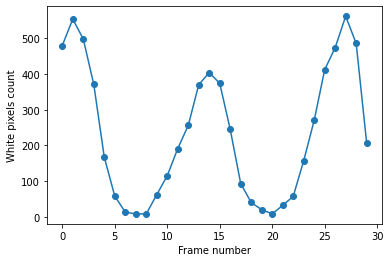

In [27]:
import matplotlib.pyplot as plt

plt.plot(range(len(pixels_count)), pixels_count, '-o')
plt.xlabel("Frame number")
plt.ylabel("White pixels count")
plt.show()